<img src="AW&H2015.tiff" style="float: left">
<br />
<br />
<br />   
# Problem P3.4 Theis solution with two pumping

In this notebook, we will work through one tutorial based the Theis solution for transient pumping, and investigate the superposition of drawdown from two interfering pumping wells. Two wells fully penetrate a 20-m-thick confined aquifer that is isotropic and homogeneous (Fig. P3.1). Storativity is estimated to be 2 x 10-5. The hydraulic conductivity is 100 m/d. The confining unit is composed of very low permeability material and is approximated as impermeable. Both wells have a radius of 0.5 m and are pumped continuously at a constant rate for 30 days; well A is pumped at 4000 L/min and well B is pumped at 12,000 L/min. Before pumping, the head is 100 m everywhere in the problem domain. The 800 m by 500 m problem domain in Fig. P3.1 is the near-field region of a problem domain that extends over many tens of square kilometers so that the aquifer effectively is of infinite extent and the composite cone of depression does not reach the boundaries after 30 days of pumping.

We simpflied it to look like this:

<img src="P3.4_figure.tiff">

Below is an iPython Notebook that builds a Theis function and plots results. 

[Acknowledgements: This tutorial was created by Randy Hunt and all failings are mine.  The exercise here is modeled after example iPython Notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]<br />

In [15]:
# Problem 3.4, page 107 Anderson, Woessner and Hunt (2015)

# import Python libraries/functionality for use in this notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import sys, os
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

# return current working directory
os.getcwd()

'/Users/rjhunt1/GitHub/Chapter_3_problems-1/P3-4_Theis'

In [2]:
# Set the name of the path to the model working directory
dirname = "P3-4_Theis"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print ('Name of model path: ', modelpath)

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print ('Model working directory already exists.')
else:
    print ('Creating model working directory.')
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_3_problems-1/P3-4_Theis
Model working directory already exists.


In [3]:
os.chdir(modelpath)
os.getcwd()

'/Users/rjhunt1/GitHub/Chapter_3_problems-1/P3-4_Theis'

In [4]:
#Define an function, class, and object for Theis Well analysis

def well_function(u):
    return scipy.special.exp1(u)

def theis(Q, T, S, r, t):
    u = r ** 2 * S / 4. / T / t
    s = Q / 4. / np.pi / T * well_function(u)
    return s

class Well(object):
    def __init__(self, x, y, rate, name):
        self.x = float(x)
        self.y = float(y)
        self.rate = rate
        self.name = name
        self.swell = None
        return

In [5]:
# Parameters needed to solve Theis
r = 500      # m
T = 2000     # m^2/d (100 m/d Kh x 20 m thick)
S = 0.00002  # unitless
t = 30.      # days

#Q = pumping rate # m^3/d - but we'll enter it below in the well info

In [6]:
# Well information
well_list =[]
well_obj = Well(250, 250, 5760, "Well A")  # 4000 L/min = 5760 m^3/d
well_list.append(well_obj)
well_list.append(Well(550, 250, 17280, "Well B")) # 12000 L/min = 17280 m^3/d

# Grid information as requested in problem
x = np.linspace(0, 800., 50)  # x-direction 0 to 800 m, 50 m increments
y = np.linspace(0, 500., 50)  # y-direction 0 to 500 m, 50 m increments
xgrid, ygrid = np.meshgrid(x, y) # make a grid with these coordinates

### We want to explore drawdown as a function of time
So, set up an array of times to evaluate, and loop over them. Also, we can specify a distance from each well at which to calculate the curve of drawdown over time.

In [7]:
times = np.linspace(0.,30.,31) # linear interpolation of time from 0 to 30 days, make 30 increments days at 0.5
rdist = 25  # this sets the distance to plot drawdown over time
print (times)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.]


### We will want to normalize our plots
Let's figure out the maximum drawdown to use for setting our colorbar on the plots.

In [8]:
#let's find the maximum drawdown
drawdown_grid_max = np.zeros(xgrid.shape, dtype=float)
for well_obj in well_list:
    r = ((well_obj.x - xgrid)**2 + (well_obj.y - ygrid) ** 2) ** 0.5
    s_max = theis(well_obj.rate, T, S, r, times[-1])
    drawdown_grid_max += s_max
max_drawdown = np.max(drawdown_grid_max)
print (max_drawdown)

15.4068299862


### Making a plot over time

### Loop over time and make figures
We will make a figure with the drawdown contours over the whole grid. 

working on time 30.0: 100.00% complete

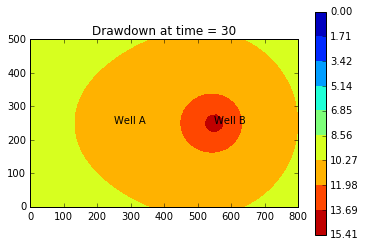

In [18]:
# Note that this section of code is saving figures for animation - not plotting them!

from IPython.display import clear_output
# to make our plots of drawdown over time a one point, we can
# predefine the response as np.nan. That way, when we plot incrementally
# as we calculate through time, only the times for which calculations
# have been made will appear using plt.plot()
for well_obj in well_list:
    well_obj.swell = np.ones_like(times)*np.nan
    
with PdfPages('Theis.pdf') as outpdf:
    # using "enumerate" we get both the iterant (t) and a counter (i)    
    for i,t in enumerate(times):
        # the following stuff just writes out a status message to the screen
        clear_output()
        perc_done = (i/float(len(times)-1)) * 100
        sys.stdout.write('working on time {0}: {1:2.2f}% complete'.format(t,
                                                                          perc_done))
        if i < len(times):
            sys.stdout.flush()
        # here's the end of the silly shenanigans of plotting out status to the screen    

        # now we calculate the drawdown for each time.
        drawdown_grid = np.zeros(xgrid.shape, dtype=float)
        for well_obj in well_list:
            r = ((well_obj.x - xgrid)**2 + (well_obj.y - ygrid) ** 2) ** 0.5
            s = theis(well_obj.rate, T, S, r, t)
            well_obj.swell[i] = (theis(well_obj.rate, T, S, rdist, t))
            drawdown_grid += s


        # drawdown contour map (map view)
        plt.subplot(1, 3, 1, aspect='equal')
        im = plt.contourf(xgrid, 
                     ygrid, 
                     drawdown_grid, 
                     np.linspace(0,max_drawdown,10))
        # optional color bar configuration
        divider = make_axes_locatable(plt.gca())
        cax = divider.append_axes("right", "5%", pad="3%")
        plt.colorbar(im, cax=cax).ax.invert_yaxis()
        for well_obj in well_list:
            plt.text(well_obj.x, well_obj.y, well_obj.name)
        plt.title('Drawdown at time = {0:.0f}'.format(t))



    # Let's finish with a drawdown only plot --> make a second set of figures with only the 
        # make a plot    
        plt.subplot(1, 1, 1, aspect='equal')
        im = plt.contourf(xgrid, 
                     ygrid, 
                     drawdown_grid, 
                     np.linspace(0,max_drawdown,10))
        plt.colorbar().ax.invert_yaxis()
        for well_obj in well_list:
            plt.text(well_obj.x, well_obj.y, well_obj.name)
        plt.title('Drawdown at time = {0:.0f}'.format(t))
        outpdf.savefig()

### Let's look at the timeseries.  

Outside of the notebook, look in the working subdirectory P3-4_Theis and open the file __Theis.pdf__ with a PDF reader.  You can move through time with the up and down arrow and on some platforms you can view the Theis.pdf as an animation by pressing and holding the down arrow.

## Testing your Skills

1.  Go to input section In[5] above and change aquifer properties and rerun the workbook.

2.  Go to input seciton In[6] above and change the pumping information and rerun the workbook.  

Do the changes in results follow your hydrologic intuition?